# Hello Numerai

<div style="text-align:center;">
<img src="https://1574901745-files.gitbook.io/~/files/v0/b/gitbook-legacy-files/o/spaces%2F-LmGruQ_-ZYj9XMQUd5x%2Favatar.png?generation=1578434196951433&alt=media" width="100" />
</div>
    
<br/>

In this notebook we will go through the basics of the tournament. Our goal is to get **your first model** set up to start competing in the tournament as quickly as possible. 
<img src="assets/hello-numerai-title.svg" />

In [1]:
# Install dependencies
!pip install -q numerapi pandas matplotlib lightgbm cloudpickle pyarrow

## 1. Dataset  

Let's download the dataset and get familar with its basic structure. 


In [2]:
# Numerai API is the official Python API client for Numerai
# We will be using it to download the dataset
from numerapi import NumerAPI
napi = NumerAPI()

# v4.1 is the latest version of the dataset
# Let's see what files are available for download
[f for f in napi.list_datasets() if f.startswith("v4.1")]

['v4.1/features.json',
 'v4.1/live.parquet',
 'v4.1/live_example_preds.csv',
 'v4.1/live_example_preds.parquet',
 'v4.1/live_int8.parquet',
 'v4.1/meta_model.parquet',
 'v4.1/train.parquet',
 'v4.1/train_int8.parquet',
 'v4.1/validation.parquet',
 'v4.1/validation_example_preds.csv',
 'v4.1/validation_example_preds.parquet',
 'v4.1/validation_int8.parquet']

In this example, we will focus on the following files:
- `features.json`: feature metadata
- `train.parquet`: historical data for training our model
- `live.parquet`: live features for making live submissions

In [3]:
import pandas as pd
import json

# Download the training data and feature metadata files
# This will take about 1 minute 🍵
napi.download_dataset("v4.1/train.parquet");
napi.download_dataset("v4.1/features.json");

# The feature metadata file contains a lot of useful information about the features
# In particular, it defines a "small" feature set that is useful for training smaller models
# In this example, we will be using the "small" feature set to save time and memory 
# In practice, you will probably want to use all the features to maximize your model's performance
feature_metadata = json.load(open("v4.1/features.json")) 
feature_cols = feature_metadata["feature_sets"]["small"]

# Load the training data but only the "small" subset of features
training_data = pd.read_parquet("v4.1/train.parquet", columns= ["era"] + feature_cols + ["target"]) 

# Let's take a look at the training data
# We limit the number of rows and columns displayed to make it easier to read
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 5)
training_data

2023-05-10 15:44:05,780 INFO numerapi.utils: target file already exists
2023-05-10 15:44:05,781 INFO numerapi.utils: download complete
2023-05-10 15:44:06,225 INFO numerapi.utils: target file already exists
2023-05-10 15:44:06,225 INFO numerapi.utils: download complete


,era,feature_bijou_penetrant_syringa,...,feature_unventilated_sollar_bason,target
id,,,,,
n003bba8a98662e4,0001,0.00,...,0.00,0.25
n003bee128c2fcfc,0001,0.50,...,0.25,0.75
n0048ac83aff7194,0001,0.25,...,1.00,0.50
n00691bec80d3e02,0001,0.75,...,0.75,0.75
n00b8720a2fdc4f2,0001,0.00,...,0.00,0.75
...,...,...,...,...,...
nffcc1dbdf2212e6,0574,1.00,...,1.00,0.75
nffd71b7f6a128df,0574,0.75,...,0.50,0.00
nffde3b371d67394,0574,0.75,...,1.00,0.25


At a high level, each row represents a stock on a specific date.


| Dataset Column     | Explanation                                                                                                                                                                                                        
| -: |:-  
| `id` | obfuscated stock_id + era, unique across the dataset (ex. TSLA at era=21)                                                                                                                                     
| `era`      | obfuscated date, chronological and each one week apart (eg. Friday Jan 31 2020)                                                                                                                               
| `features` | obfuscated stock features known on the date (eg. P/E ratio)                                                                                                                                                   
| `target`   | 20 day subsequent stock-specific return of the stock (eg. 20 day return relative to US auto sector). We ignore the first two days of stock-specific return and aggregate beginning the 3rd day from the date.

The Numerai dataset is obfuscated so that we can give it out for free. But don't worry - you won't need to know any of the obfuscated financial details of this dataset to work with it. The dataset has been meticulously cleaned and regularized, and ready to be used right away.

In [4]:
# Make our plots pretty
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

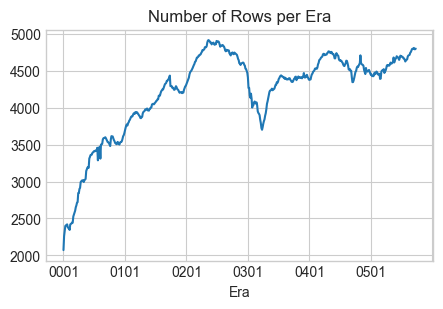

In [5]:
# Let's plot the number of rows per era
# This corresponds to the number stocks in Numerai's investable universe over time
training_data.groupby("era").size().plot(title="Number of Rows per Era", figsize=(5, 3), xlabel="Era");

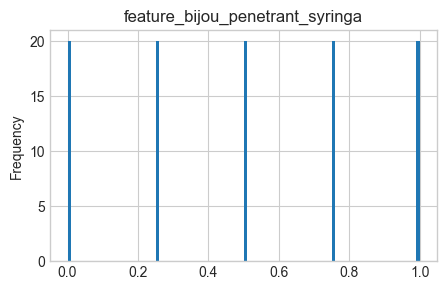

In [6]:
# Feature values are all between 0 and 1 and binned into 5 equal bins 
# Where the values (0, 0.25, 0.5, 0.75, 1.0) map to (0-20%, 20-40%, 40-60%, 60-80%, 80-100%) percentiles
training_data[feature_cols[0]].plot(kind="hist", bins=100, density=True, figsize=(5, 3), title=feature_cols[0]);

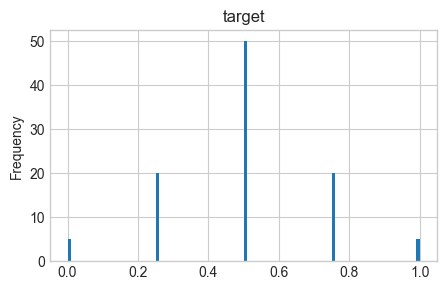

In [7]:
# The target value is also between 0 and 1 but binned into 5 unequal bins
# Where the values (0, 0.25, 0.5, 0.75, 1.0) map to (0-5%, 5-25%, 25-75%, 75-95%, 95-100%) percentiles
training_data["target"].plot(kind="hist", bins=100, density=True, figsize=(5, 3), title="target");

## 2. Modeling
Our task is to train machine learning models on the dataset to predict the target. 

Here we will be using LightGBM's Regressor as an example but you are free to model this problem using any tool or framework of your choice.


In [8]:
# LightGBM is a popular gradient boosting library that works well out of the box with Numerai's data
# Read more about LGBMRegressor here: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html 
import lightgbm as lgb

try: 
   # Load trained model if it exists
   model = lgb.Booster(model_file='small_lgb.txt');
except lgb.basic.LightGBMError:
    # Otherwise train and save the model
    # This will take about 2 minutes 🍵
    model = lgb.LGBMRegressor(
      n_estimators=2000,
      learning_rate=0.01,
      max_depth=5,
      num_leaves=2 ** 5,
      colsample_bytree=0.1
    )
    model.fit(
      training_data[feature_cols],
      training_data["target"]
    );
    # Save model to disk
    model.booster_.save_model("small_lgb.txt");

# 3. Submissions
Unlike Kaggle competitions where models are often evaluated based on their performance on a hold out test set, Numerai evaluates models based on their <ins>live performance</ins> in the real stock market.

To participate in the tournament, your model must submit predictions on live features released every day.   

Let's walk through an example of how to make a single live submission.

In [9]:
# Check the current round number 
current_round_number = napi.get_current_round()

# Download latest live features for the current round number 
napi.download_dataset("v4/live.parquet", f"v4/live_{current_round_number}.parquet")

# Load live features
live_features = pd.read_parquet(f"v4/live_{current_round_number}.parquet", columns=feature_cols)

# Generate live predictions with our trained model
live_predictions = model.predict(live_features[feature_cols])

# Format submission
submission = pd.Series(live_predictions, index=live_features.index).to_frame("prediction")
submission

2023-05-10 15:44:09,346 INFO numerapi.utils: target file already exists
2023-05-10 15:44:09,348 INFO numerapi.utils: download complete


,prediction
id,
n0005b3efea34a10,0.499191
n0022a796515081e,0.508909
n0025166fbe7d459,0.510565
n0027fecec9aa02d,0.495016
n0039c511be7fe49,0.488603
...,...
nffd0d5b086c3d06,0.488173
nffd592edbe1f79f,0.504655
nffd5c24a573721b,0.508274


The next step is to setup automation to run this pipeline every day. The easiest way to achieve this is to <ins>upload your prediction pipeline</ins> to Numerai and let us take care of running it daily. If you wish, you may also setup your own infrastructure to automate your prediction pipeline and integrate with Numerai's submission API. But this is an advanced topic that we will skip over for now. For this example, let's choose the easy path and upload our pipeline to Numerai.

At a high level, this is how uploading your pipeline works
1. You define your prediction pipeline as a python function that takes live features and outputs live predictions
2. You pickle your function using the `cloudpickle` library and upload that file to Numerai
3. Numerai will take care of running your prediction pipeline every day moving forward in our managed exection environment

The [cloudpickle](https://github.com/cloudpipe/cloudpickle) library is used by many large ML orchestration frameworks like [Dask](https://distributed.dask.org/en/stable/serialization.html) and [Ray](https://docs.ray.io/en/latest/ray-core/objects/serialization.html) to flexibly deploy ML workloads to remote execution environments. From the cloudpickle docs: "An important difference between cloudpickle and pickle is that cloudpickle can serialize a function or class <ins>by value</ins>, whereas pickle can only serialize it <ins>by reference</ins>." Here we will make use of the <ins>serialization by value</ins> feature to help us pickle our entire prediction pipeline (and not just the model itself).

Things to be aware of when pickling model pipelines
- You can safely reference any global variables (e.g. model and feature_cols) and they will be included in the pickled function
- You can safely reference most common ML libraries here (e.g. pandas, numpy, sklearn, etc.) that comes pre-installed in our managed execution environment
- You will have no access to the network or disk, so your function must be self-contained 
- Your model pipeline must complete running within 60 minutes

In [10]:
# Define any function that takes live features and returns live predictions
def predict(live_features: pd.DataFrame) -> pd.DataFrame:
    live_predictions = model.predict(live_features[feature_cols])
    submission = pd.Series(live_predictions, index=live_features.index)
    return submission.to_frame("prediction")

# Use the cloudpickle library to serialize your function and its dependencies
import cloudpickle
p = cloudpickle.dumps(predict)
with open("predict.pkl", "wb") as f:
    f.write(p)

In [11]:
# Download the model file if running in Google Colab
try:
    from google.colab import files
    files.download('predict.pkl')
except:
    pass

That's it! Now head back to [numer.ai](numer.ai) to upload your model prediction pipeline! 